# Packages

In [1]:
%pip install pyarrow
%pip install ipywidgets
%pip install ipympl
%pip install tqdm
%matplotlib widget


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import ipywidgets as widgets
import numpy as np
from tqdm import tqdm

# Load data

In [87]:
df_file = pd.read_parquet("../01_Datenaufbereitung/Output/Calculated/df_29.parquet")
df_file['Absolute_Time[yyyy-mm-dd hh:mm:ss]'] = pd.to_datetime(df_file['Absolute_Time[yyyy-mm-dd hh:mm:ss]'])
df_file = df_file[['Absolute_Time[yyyy-mm-dd hh:mm:ss]', 'Current[A]', 'Voltage[V]', 'Temperature[°C]', 'Q_sum','EFC', 'SOH_ZHU','SOC_ZHU']]

df_file["dV"] = df_file["Voltage[V]"].diff().fillna(0)
df_file["dI"] = df_file["Current[A]"].diff().fillna(0)

df_file["InternalResistance[Ohms]"] = np.where(
    df_file["dI"].abs() > 0.5,
    df_file["dV"] / df_file["dI"],
    np.nan
)

data_hourly = df_file.set_index('Absolute_Time[yyyy-mm-dd hh:mm:ss]').resample('h').mean()
data_hourly.interpolate(method='linear', inplace=True)
data_hourly.reset_index(drop=False, inplace=True)
data_hourly['Testtime[h]'] = data_hourly.index
# data_hourly

In [88]:
# data_hourly["InternalResistance[Ohms]"] =data_hourly["InternalResistance[Ohms]"].fillna(
#    data_hourly["InternalResistance[Ohms]"].rolling(5, min_periods=1).mean()
# )
data_hourly = data_hourly[['Testtime[h]','Current[A]','Voltage[V]','Temperature[°C]', 'Q_sum', 'EFC', 'InternalResistance[Ohms]','SOH_ZHU', 'SOC_ZHU']]

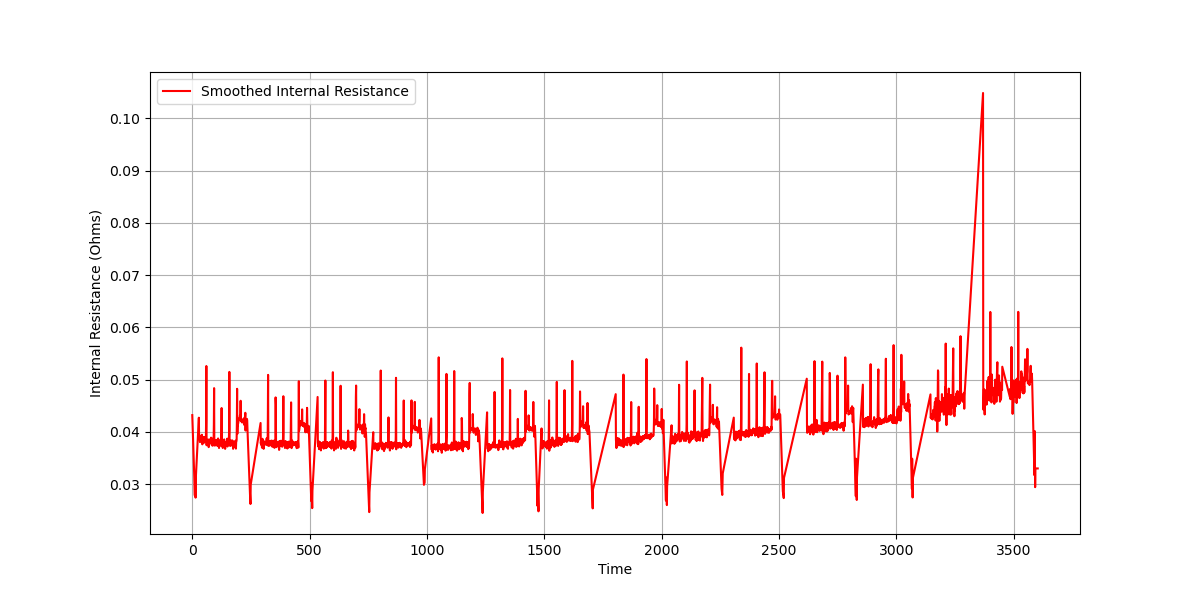

In [89]:
import matplotlib.pyplot as plt
# data_hourly["InternalResistance[Ohms]"] = data_hourly["InternalResistance[Ohms]"].interpolate(method='linear')  
# data_hourly["InternalResistance[Ohms]"] = data_hourly["InternalResistance[Ohms]"].rolling(10, min_periods=1).mean()  
# data_hourly["InternalResistance[Ohms]"] = data_hourly["InternalResistance[Ohms]"].interpolate(method='time')  
plt.figure(figsize=(12,6))
plt.plot(data_hourly["Testtime[h]"], data_hourly["InternalResistance[Ohms]"], color='red', label="Smoothed Internal Resistance")
plt.xlabel("Time")
plt.ylabel("Internal Resistance (Ohms)")
plt.legend()
plt.grid()
plt.show()

# Plot SOC SOH

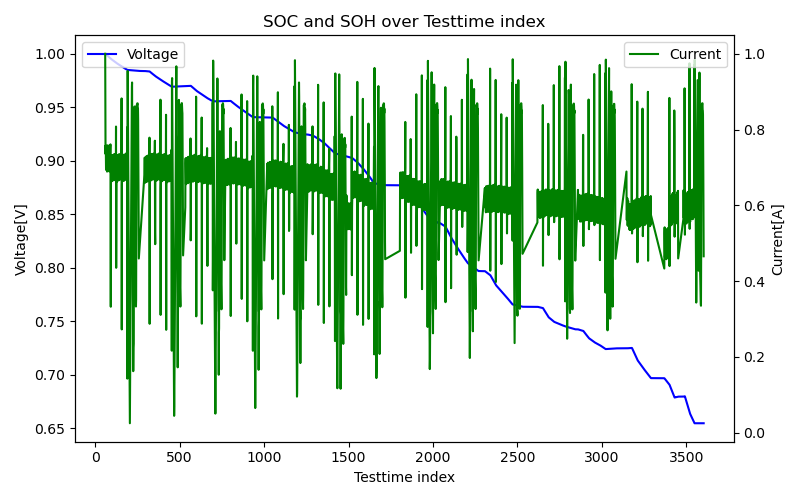

In [90]:
%matplotlib widget
fig, ax1 = plt.subplots(figsize=(8, 5))

ax1.set_xlabel('Testtime index')
ax1.set_ylabel('Voltage[V]')
ax1.plot(data_hourly['Testtime[h]'],data_hourly['SOH_ZHU'], color='blue', label='Voltage')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.set_ylabel('Current[A]')
ax2.plot(data_hourly['Testtime[h]'],data_hourly['SOC_ZHU'], color='green', label='Current')
ax2.legend(loc='upper right')

plt.title("SOC and SOH over Testtime index")
plt.xticks(rotation=45)
fig.tight_layout()  
plt.show()

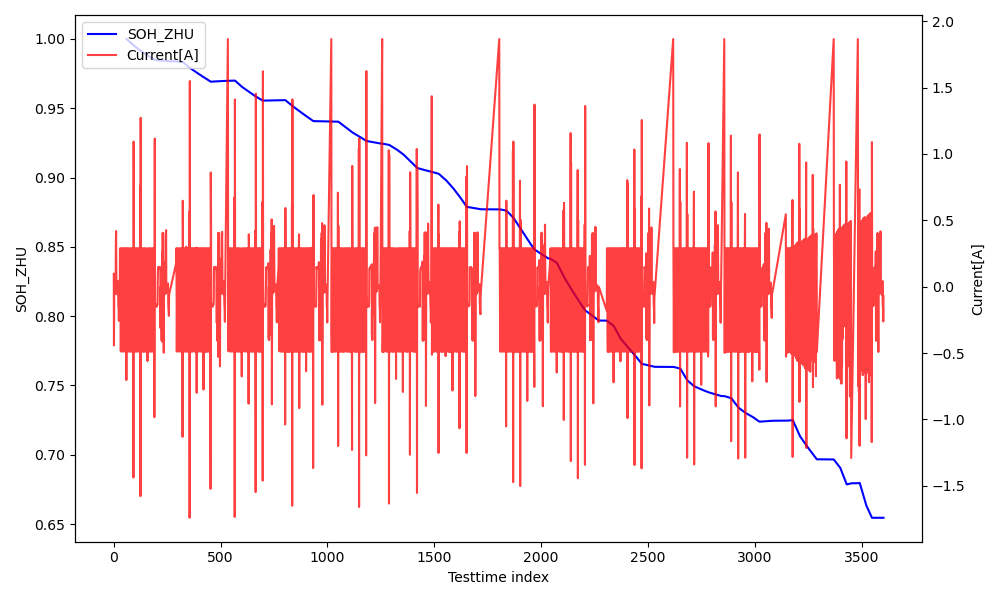

In [91]:
import ipywidgets as widgets
from IPython.display import display

# Define available columns and their labels
options = [
    ("SOH_ZHU", "SOH_ZHU"),
    ("SOC_ZHU", "SOC_ZHU"),
    ("Temperature[°C]", "Temperature[°C]"),
    ("Current[A]", "Current[A]"),
    ("Voltage[V]", "Voltage[V]"),
    ("Q_sum", "Q_sum"),
    ("EFC", "EFC"),
    ('InternalResistance[Ohms]', 'InternalResistance[Ohms]')
]

dropdown1 = widgets.Dropdown(options=options, value="SOH_ZHU", description="First:")
dropdown2 = widgets.Dropdown(options=options, value="Current[A]", description="Second:")

# Create the global figure and axes (only once)
fig, host = plt.subplots(figsize=(10, 6))
par = host.twinx()
host.set_xlabel("Testtime index")
host.set_ylabel(dropdown1.value)
par.set_ylabel(dropdown2.value)

x = data_hourly['Testtime[h]']
p1, = host.plot(x, data_hourly[dropdown1.value], "b-", label=dropdown1.value, alpha=1)
p2, = par.plot(x, data_hourly[dropdown2.value], "r-", label=dropdown2.value , alpha=0.75)

host.legend(handles=[p1, p2], loc="upper left")
plt.xticks(rotation=45)
fig.tight_layout()
plt.show()

def update_plot(change):
    # Update axis labels
    host.set_ylabel(dropdown1.value)
    par.set_ylabel(dropdown2.value)
    
    # Update data for the two lines
    p1.set_ydata(data_hourly[dropdown1.value])
    p2.set_ydata(data_hourly[dropdown2.value])
    
    # Update line labels for the legend
    p1.set_label(dropdown1.value)
    p2.set_label(dropdown2.value)
    host.legend(handles=[p1, p2], loc="upper left")
    
    # Re-calculate the limits and redraw the figure
    host.relim()
    host.autoscale_view()
    par.relim()
    par.autoscale_view()
    fig.canvas.draw_idle()

# Attach observers so that the existing plot is updated when a dropdown selection changes
dropdown1.observe(update_plot, names='value')
dropdown2.observe(update_plot, names='value')

display(widgets.HBox([dropdown1, dropdown2]))
# plt.close('all')

## Calculation

In [ ]:
# Voltage
fig, ax1 = plt.subplots(figsize=(10, 7))
ax1.set_xlabel('Absolute Time')
ax1.set_ylabel('Voltage[V]')
ax1.plot(df_file['Absolute_Time[yyyy-mm-dd hh:mm:ss]'], df_file['Voltage[V]'], color='blue', label='Voltage[V]')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.set_ylabel('Schedule_Step_ID')
ax2.plot(df_file['Absolute_Time[yyyy-mm-dd hh:mm:ss]'], df_file['Schedule_Step_ID'], color='green', label='Schedule_Step_ID', linestyle='--')
ax2.legend(loc='upper right')

plt.title(f'Voltage and Schedule Step ID over Time ')
plt.tight_layout()
plt.show()

# Current
fig2, ax3 = plt.subplots(figsize=(10, 7))
ax3.set_xlabel('Absolute Time')
ax3.set_ylabel('Current[A]')
ax3.plot(df_file['Absolute_Time[yyyy-mm-dd hh:mm:ss]'], df_file['Current[A]'], color='blue', label='Current[A]')
ax3.legend(loc='upper left')

ax4 = ax3.twinx()
ax4.set_ylabel('Schedule_Step_ID')
ax4.plot(df_file['Absolute_Time[yyyy-mm-dd hh:mm:ss]'], df_file['Schedule_Step_ID'], color='green', label='Schedule_Step_ID', linestyle='--')
ax4.legend(loc='upper right')

plt.title(f'Current over Time')
plt.tight_layout()
plt.show()



### SOH SOC calculation
1. SOH 
- Start ID 1 End ID 7
- Compte original Capacity using fully discharge time

    $Capacity(Ah)=∫_{t0}^{t1}I(t)t$

- Compute current Capacity
- Compute SOH

    $ SOH = \frac{C_{\text{current}}}{C_{\text{initial}}}$

2. SOC
- Find the start of SOC(0) = 1
- Compute SOC
 
    $SOC(t) = SOC(0) + \frac{1}{C_{nom}} \int_0^t I(t)dt *100$ 

In [ ]:
# Set start and end time
start_time = df_file['Absolute_Time[yyyy-mm-dd hh:mm:ss]'].min()
end_time = df_file['Absolute_Time[yyyy-mm-dd hh:mm:ss]'].max()

filtered_data = df_file[
    (df_file['Absolute_Time[yyyy-mm-dd hh:mm:ss]'] >= start_time) &
    (df_file['Absolute_Time[yyyy-mm-dd hh:mm:ss]'] <= end_time)
]

# dt 
filtered_data['Time_diff'] = filtered_data['Testtime[s]'].diff() / 3600
filtered_data.loc[filtered_data['Time_diff'].abs() > 0.5, 'Time_diff'] = 0
filtered_data.fillna({'Time_diff':0}, inplace=True)

# Parameter initialize SOH
C_initial = None
C_current = 0
soh_values = []

# Parameter initialize SOC
C_nom = None
filtered_data['SOC_ZHU'] = np.nan
soc_start = filtered_data.loc[filtered_data['Schedule_Step_ID'] == 5,'Absolute_Time[yyyy-mm-dd hh:mm:ss]'].iloc[0]
soc_init = 1
soc_values = []
soc_t0 = soc_init
V_max = filtered_data['Voltage[V]'].max() 
V_min = filtered_data['Voltage[V]'].min() 

# Compute SOH during fully discharge state [5,8)
for idx, row in tqdm(filtered_data.iterrows(), total=len(filtered_data), desc="Processing data"):
    # Calculate SOH
    # Fully discharge phase
    if row['Schedule_Step_ID'] in range(5, 8):  
        C_current += row['Current[A]'] * row['Time_diff']
        
    elif C_current != 0:
        #Set first fully discharge state as Initial
        if C_initial is None: 
            C_initial = C_current     
            C_nom = abs(C_initial)    
        # Calculate SOH after fully discharge
        soh_values.append((idx, C_current / C_initial))
        C_current = 0
     
    if row['Absolute_Time[yyyy-mm-dd hh:mm:ss]'] >= soc_start and C_nom:
    # Calculate SOC
        delta_soc = (row['Current[A]'] * row['Time_diff']) / C_nom 
        soc_t = soc_t0 + delta_soc
        # Reset SOC after CV phase from every Capacity test 
        if row['Schedule_Step_ID'] == 5:
            soc_t = 1.0  # Fully charged during CV phase
        elif row['Voltage[V]'] >= V_max:
            soc_t = 1.0  # SOC at 1.0 if voltage is at maximum
        elif row['Voltage[V]'] <= V_min:
            soc_t = 0.0  # SOC if voltage is at minimum

        soc_t = max(0.0, min(soc_t, 1.0))
        soc_values.append((idx, soc_t))
        soc_t0 = soc_t 

print(f"Original capacity: {abs(C_initial)} Ah") 

for idx, soh_value in tqdm(soh_values, total=len(soh_values), desc="Updating SOH"):
    filtered_data.loc[idx, 'SOH_ZHU'] = soh_value
    
filtered_data['SOH_ZHU'] = filtered_data['SOH_ZHU'].interpolate(method='linear')    

for idx, soc_value in tqdm(soc_values, total=len(soc_values), desc="Updating SOC"):
    filtered_data.loc[idx, 'SOC_ZHU'] = soc_value

filtered_data.to_parquet('df_29.parquet',index = False)
filtered_data

In [ ]:
# Data filter
# First Plot -- Voltage and Schedule Step ID
fig, ax1 = plt.subplots(figsize=(10, 7))
ax1.set_xlabel('Absolute Time')
ax1.set_ylabel('SOH')
ax1.plot(filtered_data['Absolute_Time[yyyy-mm-dd hh:mm:ss]'], filtered_data['SOH_ZHU'], color='blue', label='SOH')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.set_ylabel('Schedule_Step_ID')
ax2.plot(filtered_data['Absolute_Time[yyyy-mm-dd hh:mm:ss]'], filtered_data['Schedule_Step_ID'], color='green', label='Schedule_Step_ID', linestyle='--')
ax2.legend(loc='upper right')

plt.title(f'Voltage and Schedule Step ID over Time')
plt.tight_layout()
plt.show()

# Second Plot -- Current
fig2, ax3 = plt.subplots(figsize=(10, 7))
ax3.set_xlabel('Absolute Time')
ax3.set_ylabel('SOC')
ax3.plot(filtered_data['Absolute_Time[yyyy-mm-dd hh:mm:ss]'], filtered_data['SOC_ZHU'], color='blue', label='SOC')
ax3.legend(loc='upper left')

ax4 = ax3.twinx()
ax4.set_ylabel('Schedule_Step_ID')
ax4.plot(filtered_data['Absolute_Time[yyyy-mm-dd hh:mm:ss]'], filtered_data['Schedule_Step_ID'], color='green', label='Schedule_Step_ID', linestyle='--')
ax4.legend(loc='upper right')

plt.title(f'Current over Time')
plt.tight_layout()
plt.show()

### Delta cycle calculation

In [ ]:
cycle_capacity = 0
initial_capacity = None

df_file['Time_diff'] = df_file['Testtime[s]'].diff() / 3600
df_file.loc[df_file['Time_diff'].abs() > 0.5, 'Time_diff'] = 0
df_file.fillna({'Time_diff':0}, inplace=True)

df_file.reset_index(drop=True, inplace=True)

df_file['trend'] = np.nan

for idx, row in tqdm(df_file.iterrows(), total=len(df_file), desc="Calculating degradation trend"):
    if row['Schedule_Step_ID'] == 2:
        cycle_capacity += row['Current[A]'] * row['Time_diff']
    elif cycle_capacity != 0:
        if initial_capacity is None:
            initial_capacity = cycle_capacity
        if initial_capacity != 0:
            trend_value = 1 - abs(cycle_capacity / initial_capacity)
            df_file.at[idx, 'trend'] = trend_value
        cycle_capacity = 0
        
df_file['trend'].interpolate(method='linear', inplace=True)

In [ ]:
initial_capacity

In [ ]:
plt.figure(figsize=(8, 5))
plt.xlabel('Absolute Time')
plt.ylabel('Trend')
plt.plot(df_file['Absolute_Time[yyyy-mm-dd hh:mm:ss]'], df_file['trend'], color='blue', label='trend') 
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()